In [1]:
%load_ext autoreload
%autoreload 2

from sklearn import decomposition, cluster
import xarray as xr
import os
from src.clustering_utils import *
from src.Enumerations import Season
from src.Experiments_infos import Data
from src.plot_funcs import plot_contourf_rotated_grid

/work/aa0238/a271093/Conda/MOAAP_env/lib/python3.12/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


In [16]:
year_start = 1984
year_end = 2015


exp = Data.ICON_CNRM_EXP

slp_nc = exp.slp_nc
lon_nc = exp.lon_nc
lat_nc = exp.lat_nc 
time_nc = exp.time_nc 

path_in = exp.slp_path
name_file_slp = exp.slp_aac_name  # Area selected,  29feb deleted, all months !!!!!!

season = Season.WINTER

DO_reduce_dim = False #reduce dimensionality before applying clustering
DO_cosine_cor = False     #DO cosine correction to data before applying clustering 
                      #and transorm back afterwards


if DO_reduce_dim:
    n_components = 200  #dimensionality of reduced phase space

##################
#kmeans parameter#
##################
num_cluster = 8
num_iter = 50     # initiate algorithm n_times randomly and pick best result
random_state = 42   #reandom seed for reproducibility

In [17]:
slp_data_xr =xr.load_dataset(path_in+name_file_slp)
slp_data_xr_sel = slp_data_xr.sel(time=slp_data_xr.time.dt.month.isin(season.value)).PMSL.values
slp_data = np.reshape(slp_data_xr_sel,(slp_data_xr_sel.shape[0], slp_data_xr_sel.shape[1]*slp_data_xr_sel.shape[2])) 

In [18]:
slp_data_xr.rlon.values.shape

(193,)

In [19]:
rlat = slp_data_xr.rlat.values
rlon = slp_data_xr.rlon.values
time_frame = slp_data_xr.time.values

In [20]:
slp_data.shape

(2798, 37442)

In [21]:

if DO_cosine_cor:
    slp_data =  cosine_cor(slp_data,rlat,rlon)
    
if DO_reduce_dim:
    pca = decomposition.PCA(n_components=n_components)
    pca.fit(slp_data)
    slp_data = pca.transform(slp_data)

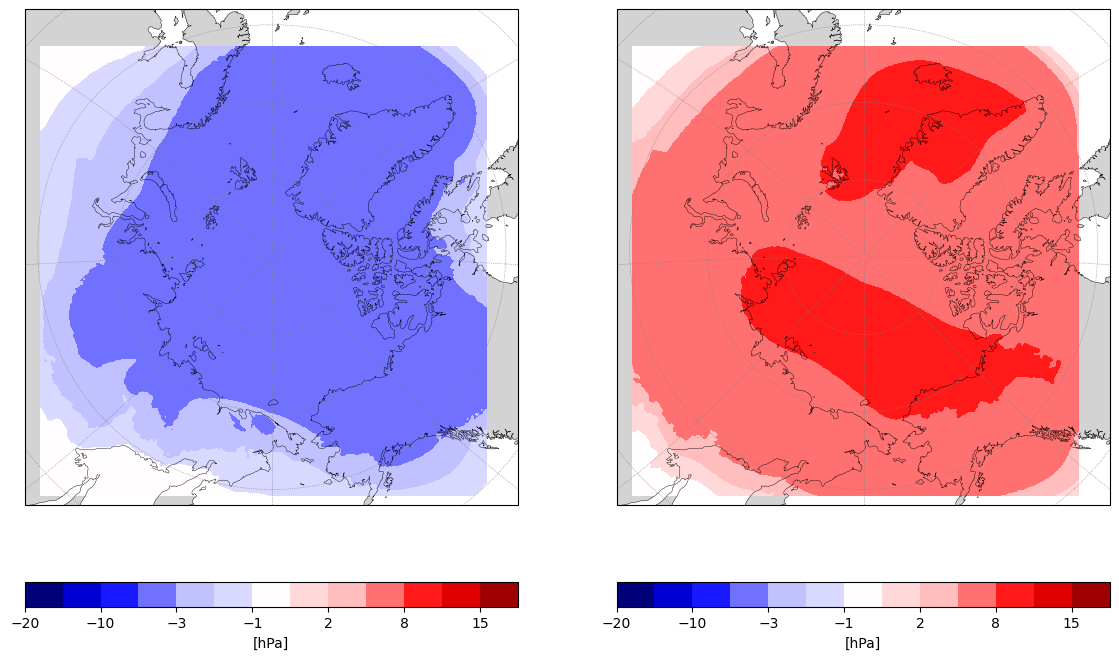

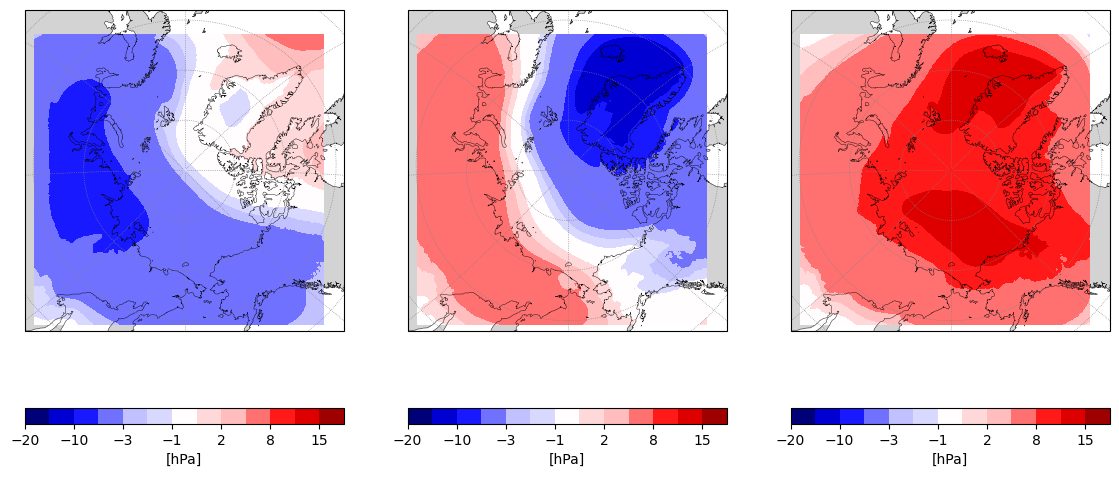

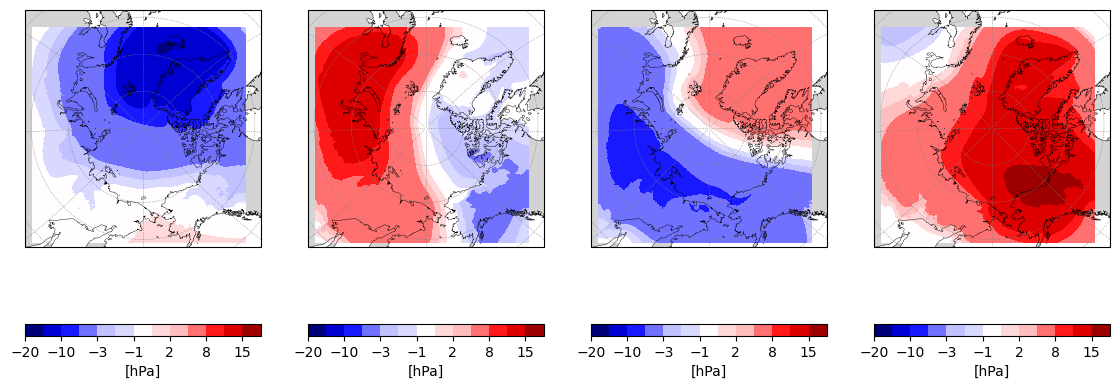

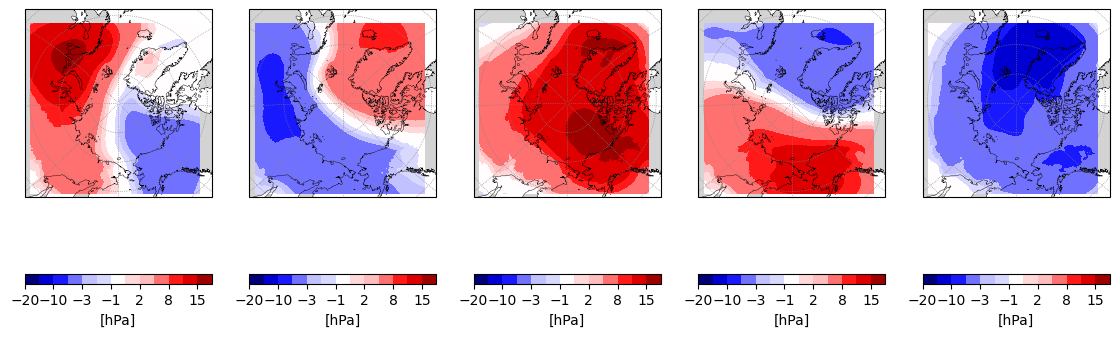

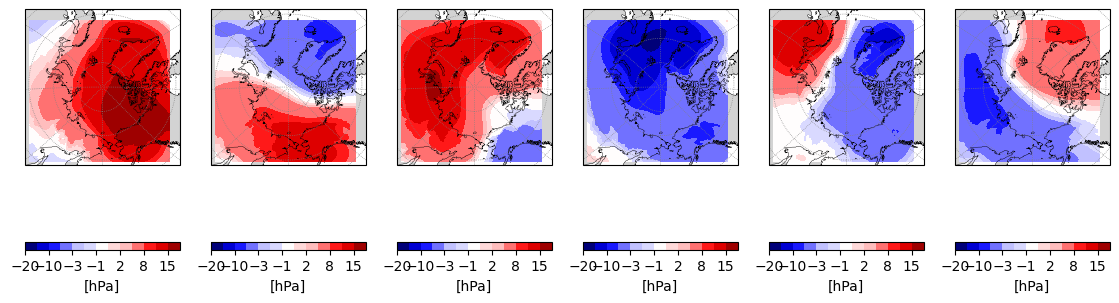

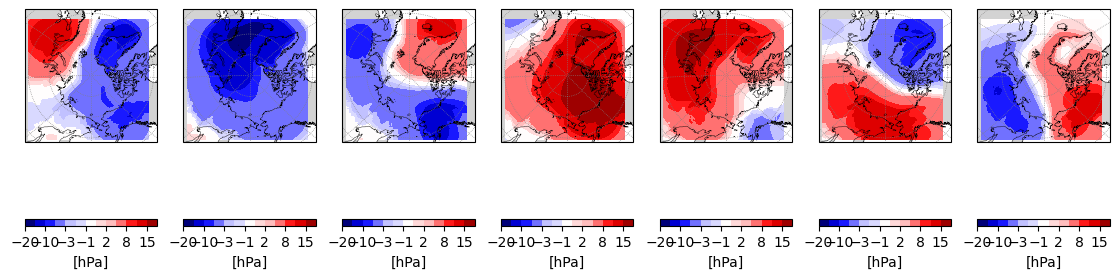

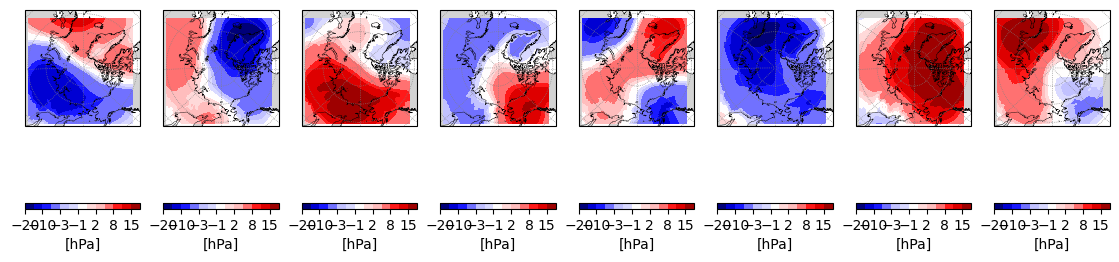

In [22]:
for num_cluster in np.arange(2,9):

    #####################
    #######         #####
    ######   KMeans  ####
    #####################


    means = cluster.KMeans(n_clusters=num_cluster,
                    n_init=num_iter,
                    max_iter=900 ,
                    random_state = random_state,
                    algorithm='lloyd').fit(slp_data)
    cluster_centers = means.cluster_centers_
    plot_len = num_cluster
    BMU = means.labels_


    if DO_reduce_dim:
        cluster_centers = pca.inverse_transform(cluster_centers)

    if DO_cosine_cor:
        cluster_centers = inv_cosine_cor(cluster_centers,rlat,rlon)





    fig = plt.figure(figsize=(14,100))

    for i in range(num_cluster):
        plot_dat = cluster_centers.reshape(-1,rlat.size,rlon.size)[i,::]

        plot_contourf_rotated_grid(rlon,
                                   rlat,
                                   plot_dat,
                                   fig=fig,
                                   index = i,
                                   subplts = (1,num_cluster),
                                   levels=[-20,-15, -10, -8, -3, -2,-1,1, 2, 3, 8, 10, 15,20],
                                   cbar_label="[hPa]")

In [88]:
cluster_centers

array([[ 9.67103   ,  9.690021  ,  9.708751  , ...,  0.1338753 ,
         0.1158597 ,  0.09717723],
       [ 0.75498253,  0.74455583,  0.7344203 , ..., -0.23030935,
        -0.22048874, -0.21264502],
       [ 3.2873585 ,  3.2942374 ,  3.3011014 , ..., -0.13666174,
        -0.13249813, -0.12473302],
       [-5.309883  , -5.3067713 , -5.3037257 , ..., -0.23549578,
        -0.24949758, -0.27072904],
       [-5.8893204 , -5.903964  , -5.918561  , ...,  0.42337236,
         0.43983755,  0.46280068]], dtype=float32)

In [90]:
cluster_dic= {3:"SCAN" , 4 : "NAO+" , 0 : "NAO-", 1 : "ATL-", 2 : "DIP"}
cluster_names = list(cluster_dic.keys())
BMU_bak = np.copy(BMU)
BMU[BMU_bak==cluster_names[0]] = 0
BMU[BMU_bak==cluster_names[1]] = 1
BMU[BMU_bak==cluster_names[2]] =2
BMU[BMU_bak==cluster_names[3]] = 3
BMU[BMU_bak==cluster_names[4]] = 4

In [92]:
BMU

array([4, 4, 4, ..., 4, 4, 4], dtype=int32)

In [115]:
list(cluster_dic.values())

['SCAN', 'NAO+', 'NAO-', 'ATL-', 'DIP']

In [117]:
BMU_df = pd.DataFrame(BMU, index=time_frame)
BMU_df.columns=["cluster_id"]

BMU_df["cluster_name"] = BMU_df.apply(lambda row: list(cluster_dic.values())[row.cluster_id], axis=1)


In [38]:
plot_dat[0,::].shape

(194, 193)

0
1
2
3
4


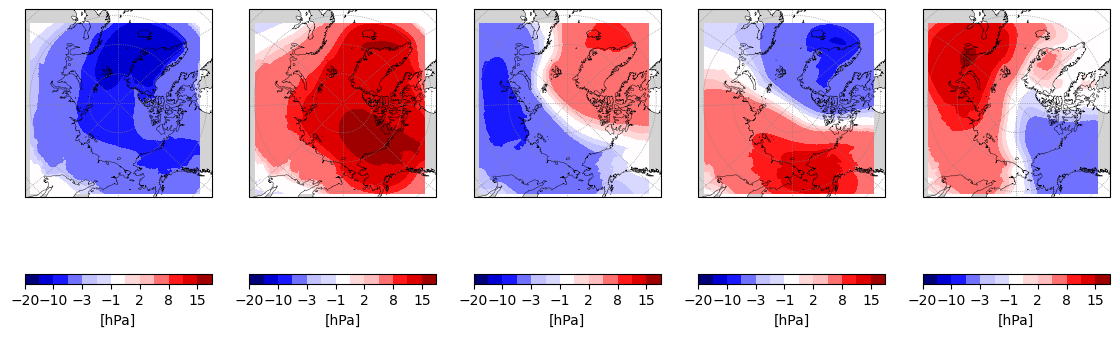

In [48]:
fig = plt.figure(figsize=(14,100))

for i in range(num_cluster):
    print (i)
    plot_dat = cluster_centers.reshape(-1,rlat.size,rlon.size)[i,::]

    plot_contourf_rotated_grid(rlon,
                               rlat,
                               plot_dat,
                               fig=fig,
                               index = i,
                               subplts = (1,5),
                               levels=[-20,-15, -10, -8, -3, -2,-1,1, 2, 3, 8, 10, 15,20],
                               cbar_label="[hPa]")

In [ ]:
fig = plt.figure(figsize=(14,80))

plot_dat = cluster_centers.reshape(-1,rlat.size,rlon.size)
cluster_names = np.arange(5)

fig_cluster = plot_cluster(plot_dat,rlat,rlon,
                            plot_size=(35, 15),
                            plot_shape=[1,5],
                            cbar_size=1,
                            cbar_ticks=[-15, -10, -8, -3, -2,-1,1, 2, 3, 8, 10, 15],
                            font_size=17,
                            unit='hPa',
                            color_lev = [-15, -10, -8, -3, -2,-1,1, 2, 3, 8, 10, 15],
                            titles =np.arange(5))